In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import imageio
from PIL import Image

In [20]:
with open('./font.bin', 'rb') as f:
    font_raw = np.frombuffer(f.read(), np.uint8)
font = np.zeros((font_raw.shape[0], 8))
for c in range(8):
    font[:, c] = np.where(font_raw & (1<<(7-c)), 1, 0)

In [21]:
PALETTE = np.array([
    (0, 0, 0), (0, 0, 127), (0, 127, 0), (0, 127, 127),
    (127, 0, 0), (127, 0, 127), (127, 127, 0), (127, 127, 127),
    (0, 0, 0), (0, 0, 255), (0, 255, 0), (0, 255, 255),
    (255, 0, 0), (255, 0, 255), (255, 255, 0), (255, 255, 255),
]) / 255

def draw_screen(cells):
    screen = np.zeros((cells.shape[0]*8, cells.shape[1]*8, 3))
    for r in range(cells.shape[0]):
        for c in range(cells.shape[1]):
            name, attr = cells[r, c, :]
            pattern = font[name*8:(name+1)*8, :]
            fore, back = PALETTE[attr & 15, :], PALETTE[(attr >> 4) & 15, :]
            im = np.dstack((
                np.where(pattern, fore[2], back[2]),
                np.where(pattern, fore[1], back[1]),
                np.where(pattern, fore[0], back[0]),
            ))
            screen[r*8:(r+1)*8, c*8:(c+1)*8, :] = im
    return screen

In [22]:
char_cells = np.zeros((50, 80, 2), np.uint8)

def text(x, y, s, attr, cells=char_cells):
    char_cells[y, x:x+len(s), 1] = attr
    char_cells[y, x:x+len(s), 0] = [ord(c) for c in s]
    
def rectfill(x, y, w, h, ch, attr):
    char_cells[y:y+h, x:x+w, :] = (ord(ch), attr)
        
def rect(x, y, w, h, attr, strong=False):
    if strong:
        H, V, TL, TR, BL, BR = [0xcd, 0xba, 0xc9, 0xbb, 0xc8, 0xbc]
    else:
        H, V, TL, TR, BL, BR = [0xc4, 0xb3, 0xda, 0xbf, 0xc0, 0xd9]
    char_cells[y, x:x+w] = (H, attr)
    char_cells[y+h-1, x:x+w] = (H, attr)
    char_cells[y:y+h, x] = (V, attr)
    char_cells[y:y+h, x+w-1] = (V, attr)
    char_cells[y, x] = (TL, attr)
    char_cells[y+h-1, x] = (BL, attr)
    char_cells[y, x+w-1] = (TR, attr)
    char_cells[y+h-1, x+w-1] = (BR, attr)
    
def bigc(x, y, ch, colour):
    for row in range(8):
        pattern = font[ord(ch)*8 + row, :]
        for col in range(8):
            if pattern[col] != 0:
                text(x+col, y+row, ' ', colour*16)
    
rectfill(0, 0, 80, 50, chr(0xb1), 0x67)
rect(0, 0, 80, 50, 0x6f)
    
rectfill(0, 0, 64, 48, chr(0xb1), 0x47)
rect(0, 0, 64, 48, 0x4f)

t = "\xb4 Hello, world \xc3"
text(64 - len(t)>>1, 0, t, 0x4f)

rectfill(2, 2, 19, 19, ' ', 0x10)
rect(2, 2, 19, 19, 0x1f)
for c in range(256):
    text(4 + (c % 16), 4 + (c // 16), chr(c), 0x1f)
for idx, x in enumerate('0123456789ABCDEF'):
    text(4+idx, 3, x, 0x17)
    text(3, 4+idx, x, 0x17)

#rect(2, 13, 34, 34, 0x2f)
for b in range(16):
    for r, s in enumerate(' \xb0\xb1\xb2'):
        for c in range(16):
            text(30 + c + 16*(b//8), 2 + r + (b%8)*4, s, b*16 + c)
            
rectfill(2, 35, 60, 11, ' ', 0x20)
rect(2, 35, 60, 11, 0x2f, strong=True)
for c in range(16):
    text(3 + 29*(c // 8), 36 + c % 8, 'Lorem ipsum dolor sit amet', 0x20 + c)
    
bigc(1, 24, 'B', 0x9)
bigc(1+7, 24, '\xa3', 0xa)
bigc(1+2*7, 24, 'r', 0xb)
bigc(1+3*7-1, 24, 'i', 0xc)

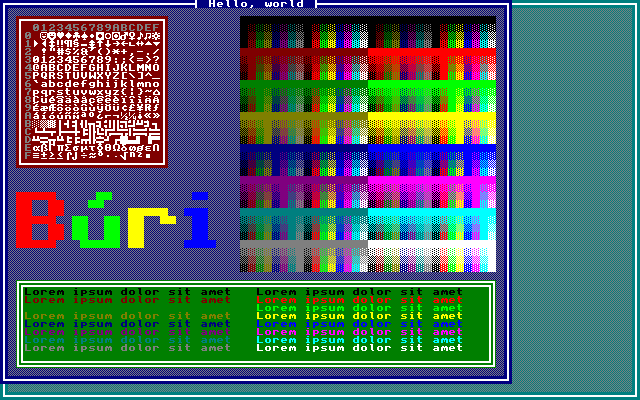

In [23]:
screen = Image.fromarray((255 * draw_screen(char_cells)).astype(np.uint8))
screen

In [24]:
with open('vram.bin', 'wb') as f:
    f.write(char_cells)
    
from intelhex import bin2hex
bin2hex('vram.bin', 'vram.hex')

0